In [2]:
from matplotlib import pyplot as plt
from AI.extract_data.get_problem_data import get_response_from_claude
from AI.image_segmentation.crop_pieces import model_predict
from cheada.domain.textBook_preprocessing.dto.ProblemInfoDto import ProblemInfoDto
from cheada.domain.textBook_preprocessing.service.image_service import upload_image_to_s3
from cheada.globalUtils.global_vars import temp_page_storage, temp_problem_storage, local_textbook_dir

import os, fitz, cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

def determine_vertical_line(pix, index):
    image_bytes = pix.samples
    image = np.frombuffer(image_bytes, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
    if pix.n == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, binary_image = cv2.threshold(gray_img, 240, 255, cv2.THRESH_BINARY)
    height, width = binary_image.shape
    center = width // 2
    thickness = 20 # 검사할 선의 두께
    center_line = binary_image[100:height-100, center-thickness//2:center+thickness//2]
    
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(center_line, cv2.MORPH_OPEN, kernel)
    
    for r in range(20, opening.shape[0], 20):
        piece = opening[r-20:r, :]
        y_coords, x_coords = np.where(piece == 0)

        if y_coords.size == 0 or np.max(piece) == 0:
            return

        prev_y, prev_x = y_coords[0], x_coords[0]
        for y in y_coords:
            if abs(y-prev_y) >= 5:
                return
            prev_y = y

    # plt.title(f"{index}")
    # plt.imshow(opening, cmap='gray_r')
    # plt.show()
    return True

    
def convert_pdf_to_png_0(pdf_file, output_folder, pdf_page_number = 0):
    pure_file_name = os.path.basename(pdf_file)[:-4].replace(" ", "")

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    doc = fitz.open(pdf_file)

    
    try:
        if pdf_page_number == 0: # pdf_page_number 특정 값 미지정 시, 전체 변환
            for i, page in enumerate(doc):
                img = page.get_pixmap(dpi=300)   # 이미지 변환
                if determine_vertical_line(pix=img, index=i+1):
                    img.save(output_folder + "\\" + pure_file_name + f'_{i}th_problem_page.png') # 변환된 이미지 저장
                    plt.imshow(img)
                    plt.show()
            print('전체 변환')
        elif pdf_page_number != 0:
            page = doc.load_page(pdf_page_number - 1) # 특정 페이지 가져오기
            i = pdf_page_number
            img = page.get_pixmap()   # 이미지 변환
            img.save(output_folder + "\\" + pure_file_name + f'_{i}_only_output.png') # 변환된 이미지 저장
            
            print(pdf_page_number, '페이지 변환')

        
    except ValueError:
        print('Error: page not in document')


def convert_pdf_to_png(pdf_file, output_folder, pdf_page_number = 0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    doc = fitz.open(pdf_file)
    
    try:
        if pdf_page_number == 0: # pdf_page_number 특정 값 미지정 시, 전체 변환
            for i, page in tqdm(enumerate(doc), total=len(doc)):
                img = page.get_pixmap()   # 이미지 변환
                if determine_vertical_line(pix=img, index=i+1):
                    try:
                        img.save(os.path.join(output_folder, f"{i}.png"))
                    except Exception as e:
                        print(f"Error saving image {i}: {e}")
                
            print('전체 변환')
            
        elif pdf_page_number != 0:
            page = doc.load_page(pdf_page_number - 1) # 특정 페이지 가져오기
            i = pdf_page_number
            img = page.get_pixmap()   # 이미지 변환
            img.save(os.path.join(output_folder, f'{i}_only_output.png'))
            
            print(pdf_page_number, '페이지 변환')

        
    except ValueError:
        print('Error: page not in document')


def start_preprocessing(fileName, local_textbook_dir, temp_page_storage, temp_problem_storage):
    print("\nstart preprocess thread\n")
    # 1. pdf를 png로 바꾸고
    if os.path.exists(temp_page_storage):
        print("해당 문제집은 이미 이미지로 변환된 상태입니다.")
    else:
        print('변환')
        convert_pdf_to_png(pdf_file=f"{local_textbook_dir}\\{fileName}", output_folder=temp_page_storage)
    
    # 2. png마다 문제 crop하고 추출
    print("2. png마다 문제 crop하고 추출")
    model_predict(image_dir=temp_page_storage, save_location=temp_problem_storage)
    
    # 3. crop한 문제 s3에 업로드
    for i, page_img in enumerate(os.listdir(rf"{temp_page_storage}")): 
        response = get_response_from_claude(image_path=f"{temp_page_storage}\\{page_img}", subject="수학 II")
        print(response)
        if i == 3: break


convert_pdf_to_png(pdf_file=f"{local_textbook_dir}\\[블랙라벨] 수학 II.pdf", output_folder=temp_page_storage)

ModuleNotFoundError: No module named 'AI'

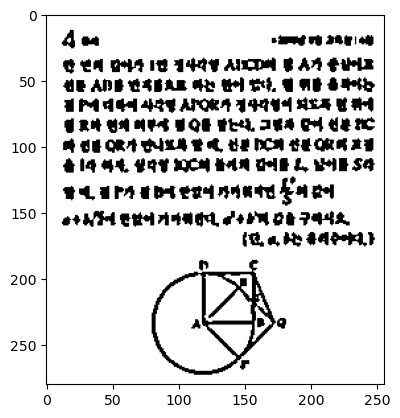

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def improve_text_quality(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to binarize the image
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    
    # Use morphology to enhance text
    kernel = np.ones((1, 1), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.dilate(morphed, kernel)
    
    # Increase contrast
    contrast = cv2.convertScaleAbs(morphed, alpha=1.5, beta=0)
    
    plt.imshow(contrast, cmap='gray')
    plt.show()
    

improve_text_quality(r'C:\Users\aiotu\Projects\GradProj\cheada_fastapi\cheada\globalUtils\temp_problem_storage\0.png')